<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

A edição de maio do problema de classificação binária da série Tabular Playground de 2022 que inclui várias interações de variáveis diferentes, as variáveis são dados de fabricação simulados que devem ser usados para prever o estado binário (alvo) da máquina que é 0/1. 

A motivação não é apenas prever o estado da máquina com as variáveis simuladas, mas também descobrir a interação de 'ocultas' que pode ajudar a melhorar a precisão da previsões.

Esta competição é uma oportunidade para explorar vários métodos que ajudem a identificar essas interações entre as variáveis. 

Fora isso, a página de descrição de dados informa que os dados incluem dados contínuos normalizados e dados categóricos.


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados
- Calculando estatísticas sobre o conjunto de dados
- Visualização univariada
- Visualizando multivariada
- Pré-processamento 




---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q optbinning
    !pip install --q catboost
    !pip install --q pandas-profiling
    !pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import shap

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go

In [4]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing   import PowerTransformer, RobustScaler, Normalizer
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn                 import metrics
from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix

In [5]:
from sklearn.compose         import ColumnTransformer, make_column_transformer
from sklearn.pipeline        import Pipeline, make_pipeline
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster         import KMeans, AgglomerativeClustering

In [6]:
from sklearn.cluster         import KMeans
from sklearn.mixture         import GaussianMixture
from sklearn.preprocessing   import StandardScaler

In [7]:
from datetime                import datetime

---

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [8]:
class Ultil():
    
    import sklearn.exceptions
    
    def __init__(self):
        pass
    
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', None)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.3*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     

            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        #ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        #y_fmt = tick.FormatStrFormatter('%.0f') 
        #ax.yaxis.set_major_formatter(y_fmt)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)

        graf_label(ax, total)

    def graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache():

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(Ultil.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )

            
            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))

    def plot_roc_curve(fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(y_, predictions_):
        mae  = metrics.mean_absolute_error(y_, predictions_)
        mse  = metrics.mean_squared_error(y_, predictions_)
        rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape = metrics.mean_absolute_percentage_error(y_, predictions_)
        r2   = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2
    
    def feature_statistic(df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df


In [9]:
icecream, colors, color_cols = Ultil.jupyter_setting()

---

## 1.4. Dataset

### 1.4.1. Descrição de dados

Para este desafio, temos um conjunto de dados de controle de fabricação (simulados) e temos a tarefa de prever se a máquina está em estado 0 ou estado 1, os dados têm várias interações de variáveis que podem ser importantes na determinação do estado da máquina, o qual devemos identificar para uma boa tareja de previsão. 


### 1.4.2. Arquivos
- **treino.csv**: conjunto de treinamento, que incluem dados contínuos normalizados e dados categóricos;
- **teste.csv**: conjunto de teste, a tarefa é prever um binário para target que representa o estado de um processo de fabricação
- **sample_submission.csv**: um arquivo de envio de amostra no formato correto

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [10]:
path        = '/content/drive/MyDrive/Flai/09/' if COLAB else ''   
path_data   = 'Data/'  
path_automl = 'automl/'

In [11]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

### 1.4.4. Carrega dados

In [12]:
df1_train     = pd.read_csv(path + path_data + 'data.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.shape,  df_submission.shape

((98000, 30), (98000, 2))

In [13]:
df1_train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,5,13,6,6,-0.469819,0.358126,1.068105,-0.559650,-0.366905,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,4,6,16,9,0.591035,-0.396915,0.145834,-0.030798,0.471167,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,8,9,3,11,-0.679875,0.469326,0.349843,-0.288042,0.291470,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,8,9,6,4,-0.389456,0.626762,-1.074543,-1.521753,-1.150806,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,3,1,13,11,-0.120743,-0.615578,-1.064359,0.444142,0.428327,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.


In [14]:
df2_train = df1_train.copy()

## 2.1. Dimensão do DataSet

In [15]:
print('TREINO')
print('Number of Rows: {}'.format(df2_train.shape[0]))
print('Number of Columns: {}'.format(df2_train.shape[1]), end='\n\n')

TREINO
Number of Rows: 98000
Number of Columns: 30



---

## 2.2. Tipo de dados

In [16]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int64  
 1   f_00    98000 non-null  float64
 2   f_01    98000 non-null  float64
 3   f_02    98000 non-null  float64
 4   f_03    98000 non-null  float64
 5   f_04    98000 non-null  float64
 6   f_05    98000 non-null  float64
 7   f_06    98000 non-null  float64
 8   f_07    98000 non-null  int64  
 9   f_08    98000 non-null  int64  
 10  f_09    98000 non-null  int64  
 11  f_10    98000 non-null  int64  
 12  f_11    98000 non-null  int64  
 13  f_12    98000 non-null  int64  
 14  f_13    98000 non-null  int64  
 15  f_14    98000 non-null  float64
 16  f_15    98000 non-null  float64
 17  f_16    98000 non-null  float64
 18  f_17    98000 non-null  float64
 19  f_18    98000 non-null  float64
 20  f_19    98000 non-null  float64
 21  f_20    98000 non-null  float64
 22

In [17]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')

=== For Pandas ==========
float64    22
int64       8
dtype: int64


In [18]:
feature_float = df2_train.select_dtypes(np.float64).columns.to_list() 
feature_int   = df2_train.select_dtypes(np.int64).columns.to_list() 
feature_int.remove('id')

Vamos dar uma olhada nas variáveis do tipo int64.  

In [19]:
for col in df2_train[feature_int]:   
    num = df2_train[col].unique().tolist()
    num.sort()
    print('-'* 70)
    print('{} unique: {}'.format(col, num))    
    print('-'* 70)
    print()

----------------------------------------------------------------------
f_07 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_08 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_09 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_10 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que as variáveis acima segue um ordem, provavelmente foram transformadas em ordinal no processo de geração dos datasets, sendo assim, temos que utilzar no normalizador que não altere essa ordem, isso pode ser um diferencial para a modelagem. 
    
</div>

---

## 2.3. Identificar NA

In [21]:
missing = Ultil.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 30 colunas e 98000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados







<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>


Não temos valores ausentes. 
    
</div>

In [22]:
duplicates = df2_train['id'].duplicated().sum()
print('Duplicates in data: {0}'.format(duplicates))

Duplicates in data: 0


## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [23]:
df2_train.drop('id', axis=1).describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
f_00,98000.000000,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.000000,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.000000,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.000000,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.000000,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.000000,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.000000,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.000000,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.000000,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.000000,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que temos três grupos: 

1. O primeiro grupo de f_00 a f_06 e de f_14 a f_21 com média zero e desvio padrão 1;
2. O segundo grupo de f_07 a f_13 com média em torno de 6 a 8 com desvio padrão em torno de 3 a 6;
3. O terceiro grupo de f_22 a f_28 com media em torno 1 a 2 com devio padrão entre 1 e 2.

    
</div>

In [95]:
feature_grup_1 = df2_train.columns[1:8].to_list()
feature_grup_2 = df2_train.columns[8:15]
feature_grup_3 = df2_train.columns[23:]

for col in df2_train.columns[15:23]:
    feature_grup_1.append(col)

---

## 2.5. Dados Númericos

### 2.5.1. Correlação
Vamos examinar a correlação entre as variáveis.

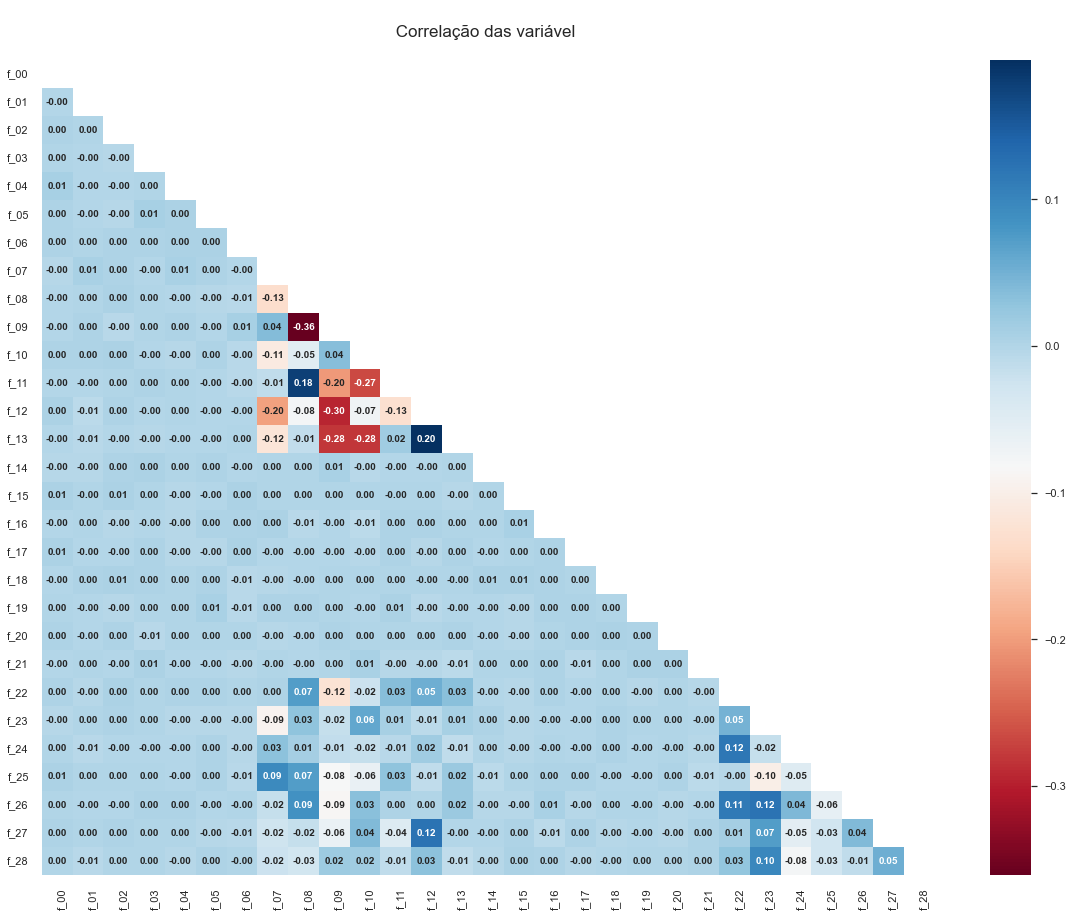

Não tem variáveis autocorrelacionadas threshold=0.70


In [24]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(20,15))

Ultil.graf_feature_corr(df_         = df2_train.drop('id', axis=1).copy(), 
                        annot_      = True, 
                        threshold_  = .7, 
                        print_var_  = True, 
                        print_graf_ = True, 
                        mask_       = True);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Como podemos observar, a correlação fica entre -0.3 e 0.1, sendo assim, não temos variáveis autocorrelacionadas, mais a frente com a criação de novas variáveis podemos ter variáveis autocorrelacionadas e voltaremos a fazer essa análise de autocorrelação.
    
</div>

### 2.5.2. Histograma

Vamos plotar apenas as variáveis float. 

In [58]:
sns.set(style="darkgrid")

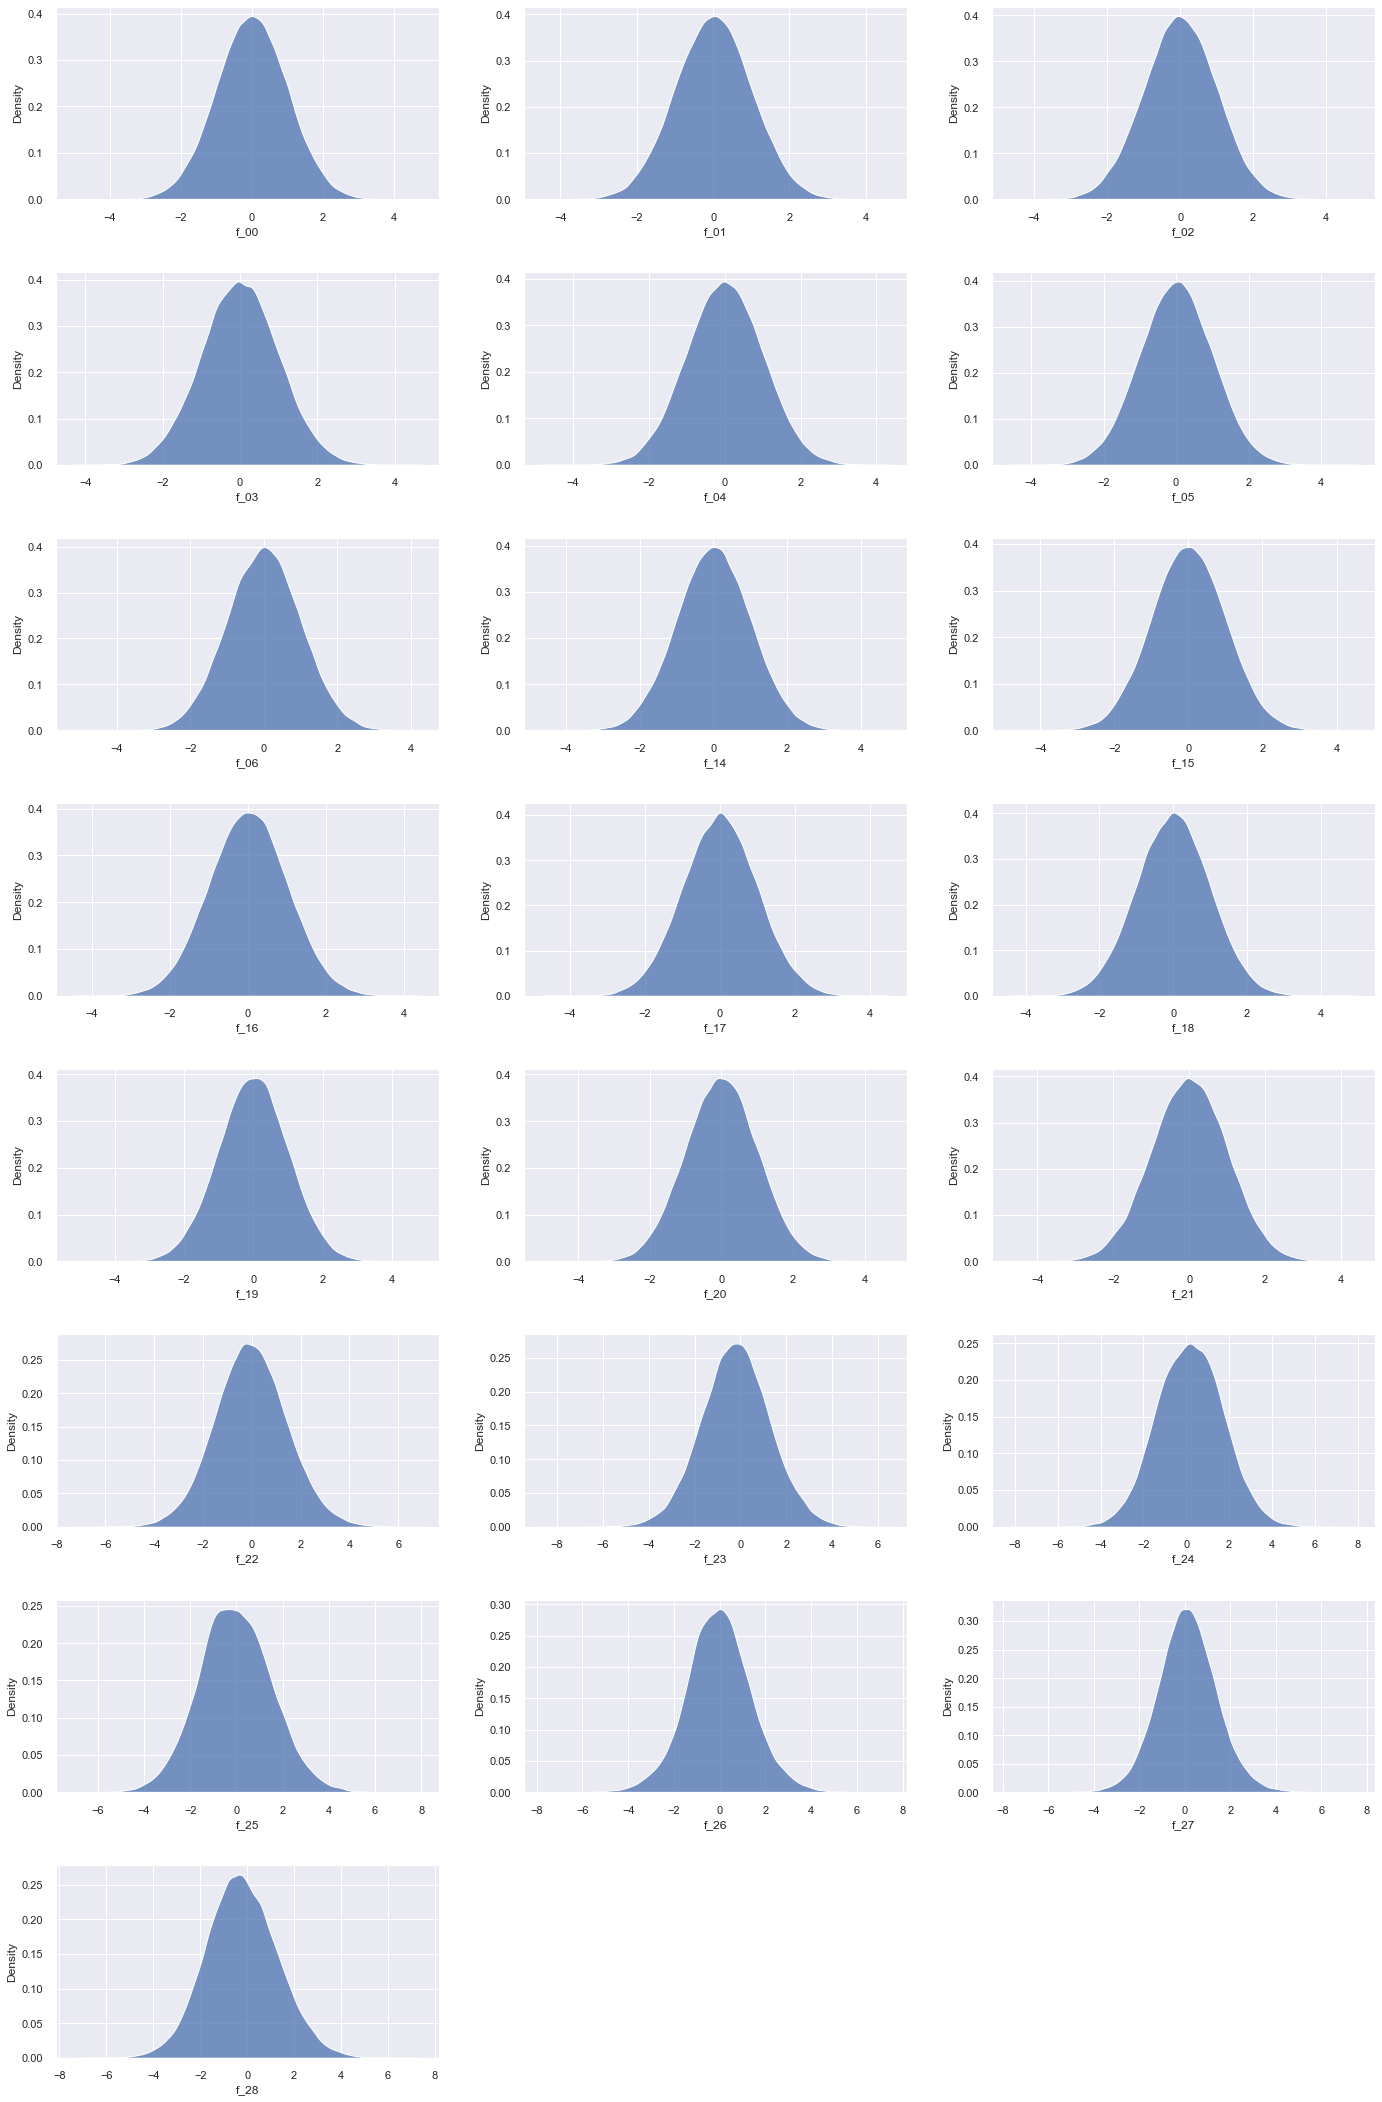

In [27]:
plt.subplots(figsize=(20, 30))

for i, col in enumerate(feature_float):    
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.kdeplot(data=df2_train, x=col, shade=True, multiple='stack')
    
plt.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- A maioria das variávies tem um distribuição comportada com a média em zero, talvez essas variáveis não sejam úteis na modelagem.    
     
<br> 
Vamos dar uma olhda nos outliers dessas variáveis. 
    
</div>

---

### 2.8.3. Outliers

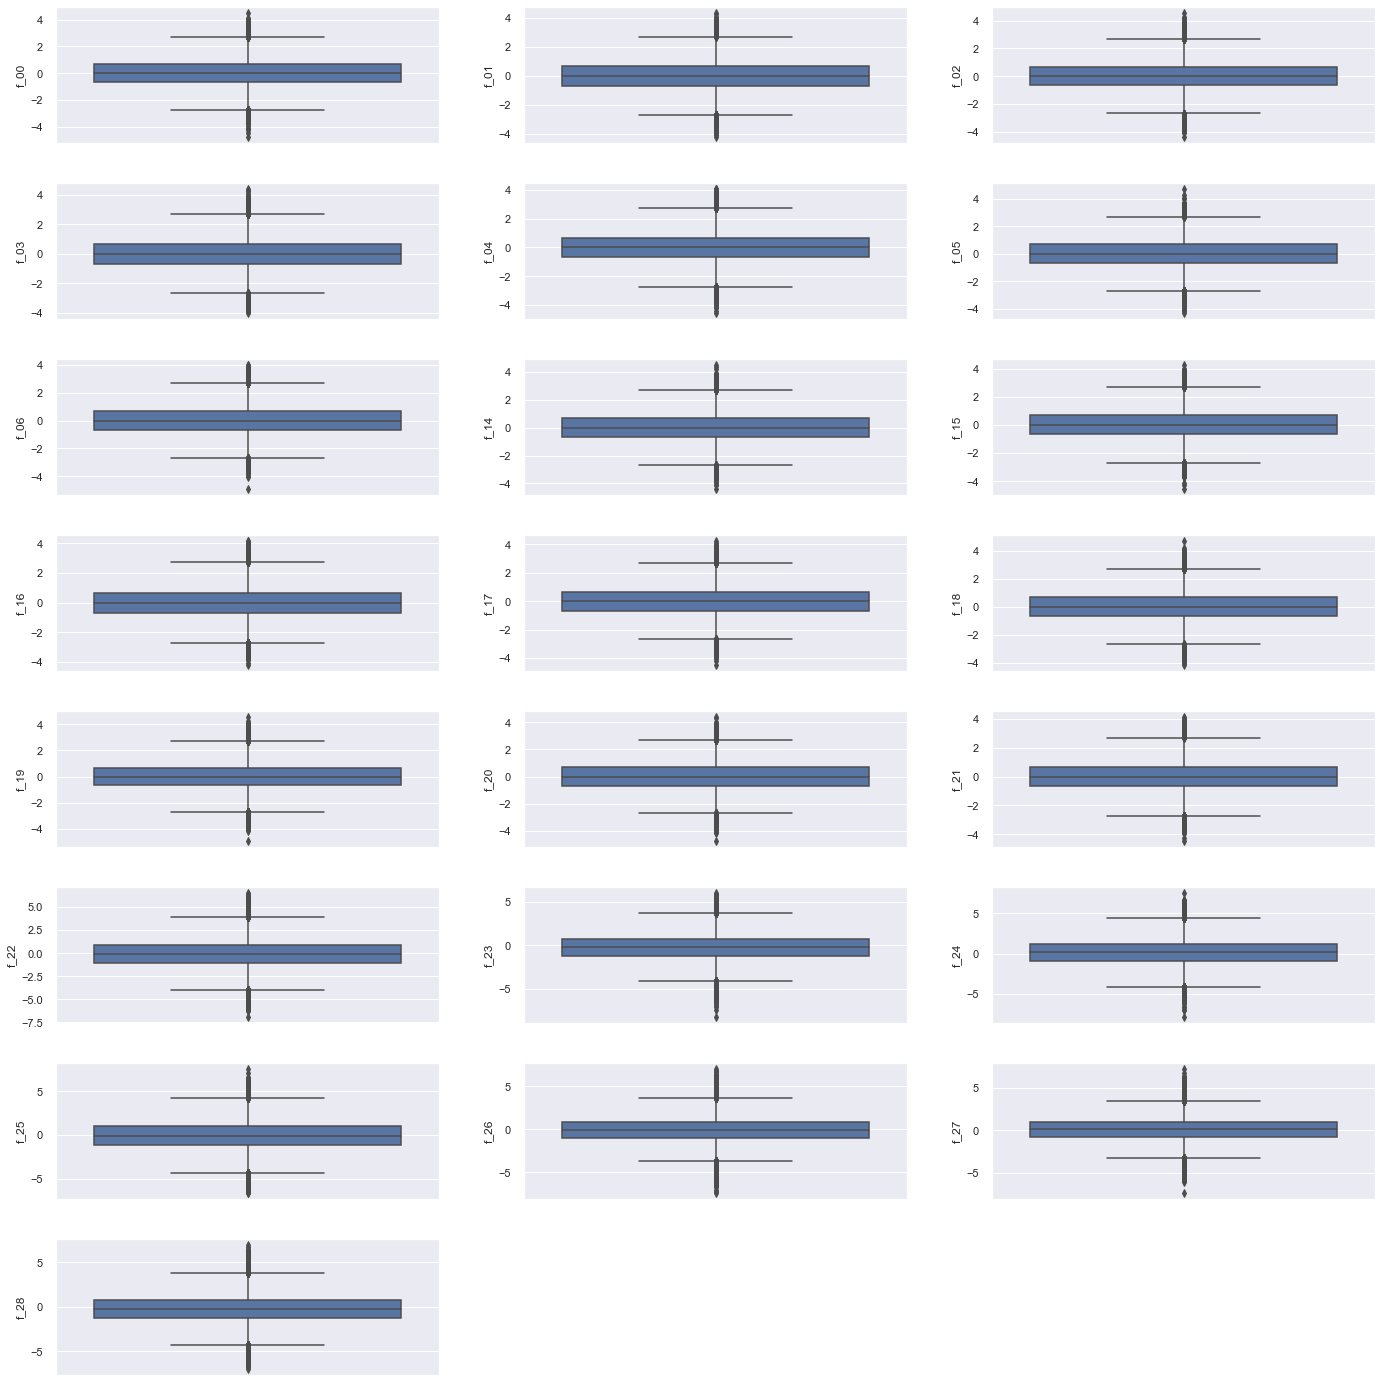

In [59]:
f, ax = plt.subplots(figsize=(20, 20))

for i, col in enumerate(feature_float): 
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.boxplot(data=df2_train,  y=col)   
    
plt.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
- Todas variáveis tem outliers, uma boa ideia é criar uma nova variável que indica se é outlier ou não, utilizando o intervalo interquartil, isso pode ajudar os modelos de clusteização.     
    
<br>
    
Vamos plotar um gráfico de iteração das variáveis.
    
</div>


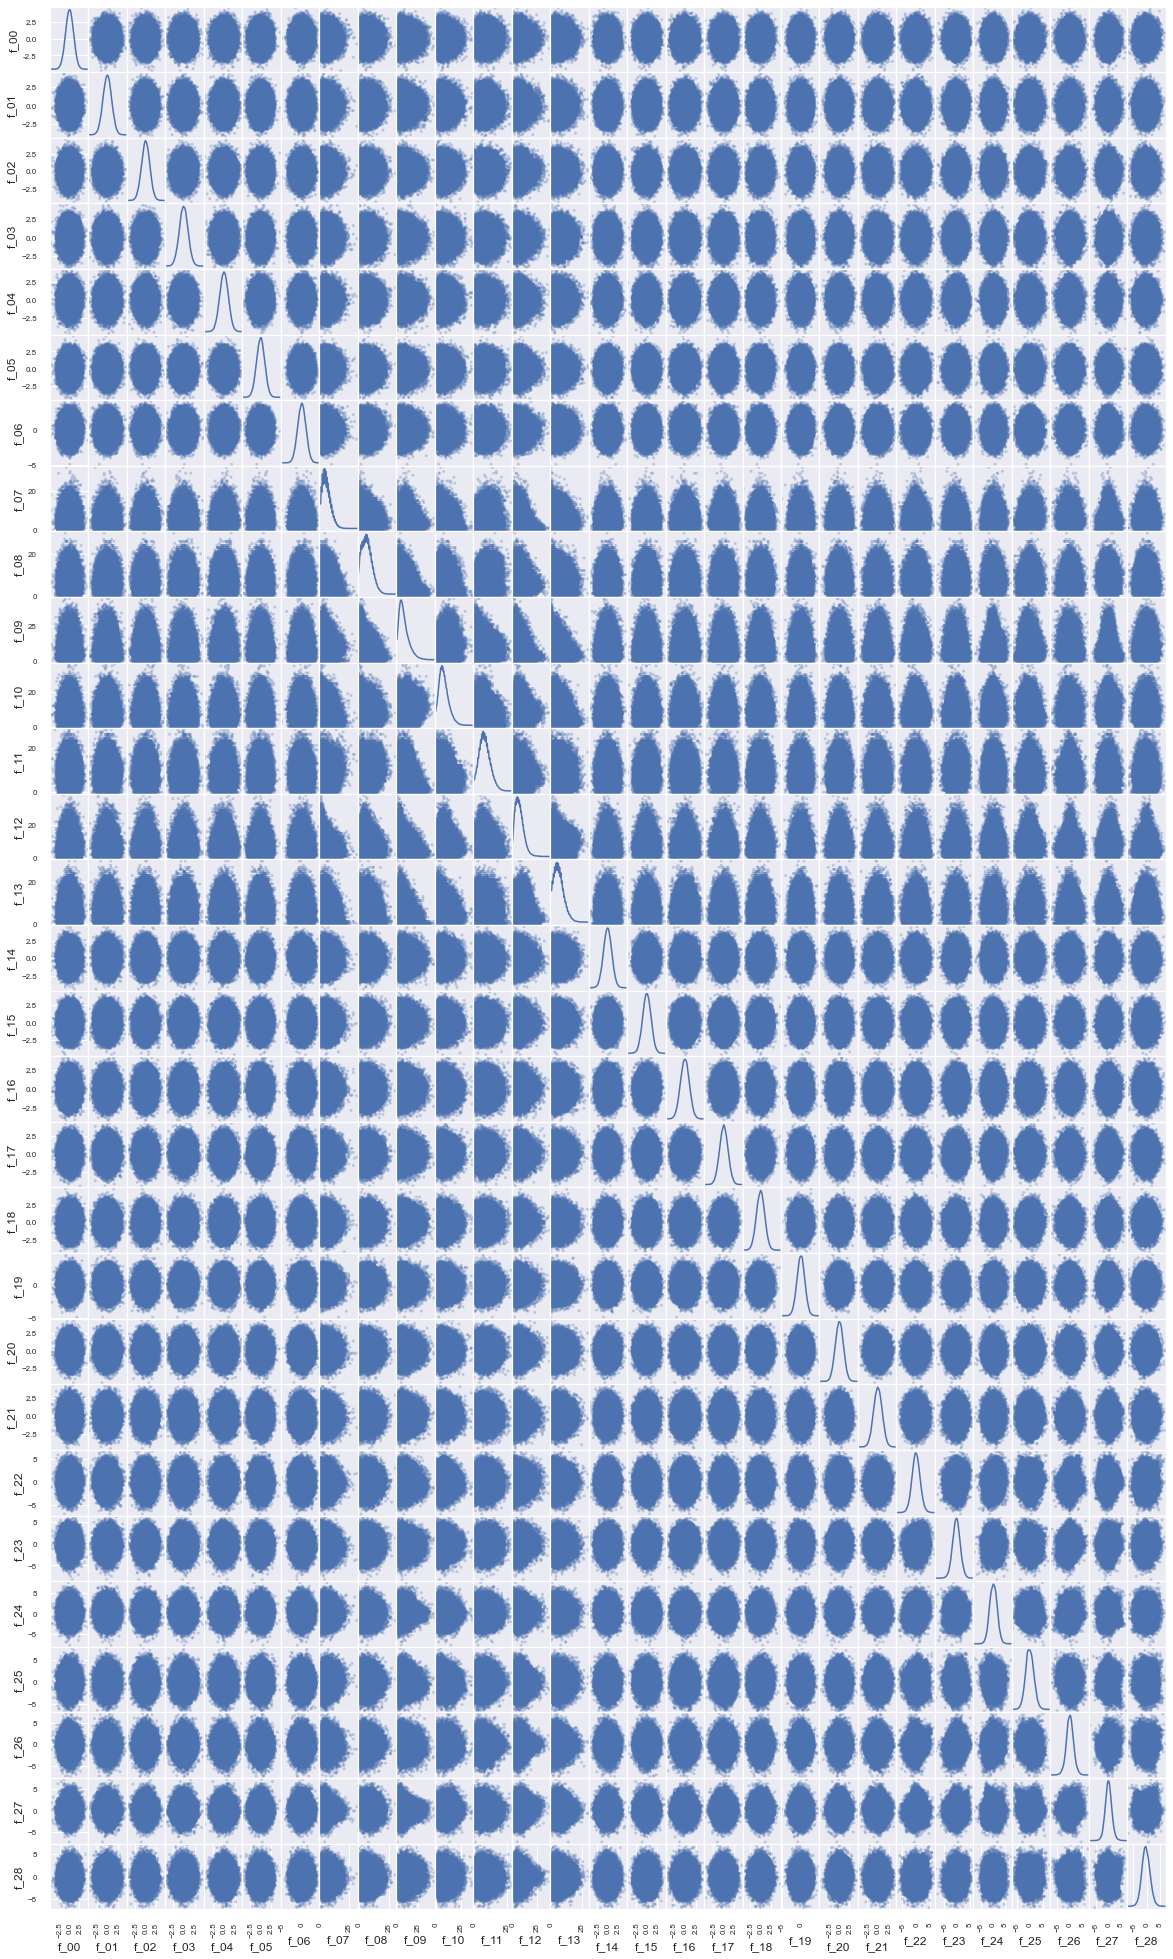

In [32]:
pd.plotting.scatter_matrix(df2_train.drop('id', axis=1), 
                           alpha    = 0.3, 
                           figsize  = (20,50), 
                           diagonal = 'kde');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não conseguimos indentificar um padrão no gráfico acima, uma opção é utilizar a PCA para reduzir a variância dos dados, pode ajudar os modelos a encontrar padrões nos dados reduzidos com a PCA, neste caso seria podemos fazer alguns teste de PCA apenas com as variáveis de ponto flutuante (float).
    
 </div>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. Modelagem (baseline) </h1>    
</div>


In [197]:
seed = 12359

df3_train = df2_train.copy().drop('id', axis=1)
X         = df3_train.copy()

## 3.1. Processamento

Para o pre-processamento vamos apenas utilizar dois scalers: QuatileTransformer e MinMaxScaler, o MiMaxScaler será ultilizado nas variáveis do tipo inteiro e QuantileTransformer nas variáveis float.

In [204]:
sc_qt = QuantileTransformer(output_distribution='normal', random_state=0)
sc_mm = MinMaxScaler()

X_sc = X.copy()
X_sc[feature_int] = sc_mm.fit_transform(X_sc[feature_int])
X_sc              = pd.DataFrame(sc_qt.fit_transform(X_sc), columns=X_sc.columns)
X_sc.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389863,-0.915229,0.646965,0.592287,-0.819715,0.733183,2.257271,-0.931971,1.397837,1.016672,-0.582009,1.135284,-0.109365,0.042668,-0.473195,0.358533,1.061649,-0.561796,-0.363243,-0.474166,-0.747787,-0.762816,-0.720598,0.932186,-0.661545,0.768702,1.004458,1.090660,0.701521
1,-0.688823,-0.458569,0.651799,0.997235,-1.648351,0.860734,-0.090538,-0.931971,-0.807429,-0.180377,-0.853480,-0.432104,1.780005,0.711981,0.585799,-0.392488,0.136696,-0.033704,0.479374,-0.425253,-0.089060,-1.768969,-0.546778,0.469018,1.037751,-0.109040,-0.575927,0.387355,-1.653005
2,0.804844,0.317933,-1.164294,-0.624129,0.108073,0.782223,1.989443,-0.003764,0.993800,-0.397918,0.125788,0.284828,-0.895780,1.111702,-0.682814,0.471615,0.338413,-0.290898,0.295219,-0.409706,-1.595868,1.193876,2.165030,0.088523,-1.537617,-0.566463,1.022400,-0.965420,-2.254593
3,-0.499385,0.221065,0.262701,0.228967,0.415213,-1.215371,0.142363,0.248427,-1.111702,0.895780,0.125788,0.284828,-0.109365,-0.443149,-0.390468,0.627989,-1.074337,-1.521864,-1.147532,0.622640,1.282299,0.529706,0.747547,-1.235296,0.822618,-1.193187,-0.408818,-0.105976,0.331211
4,-0.670178,-1.042559,-0.271812,-1.824183,-0.283041,-1.851485,0.785958,0.718462,0.132113,-0.397918,-1.142483,-1.858747,1.301191,1.111702,-0.124027,-0.611809,-1.064387,0.444564,0.436117,-1.610226,-0.429467,0.317171,0.233511,-1.496929,0.845676,-0.615525,1.205736,-0.397798,-1.178046


## 3.2. K-means Clustering

Vamos definir o número de cluster, utilizando três métricas para avaliação: 
- distortion
- silhouette
- calinski_harabasz


CPU times: total: 1h 3min 23s
Wall time: 19min 51s


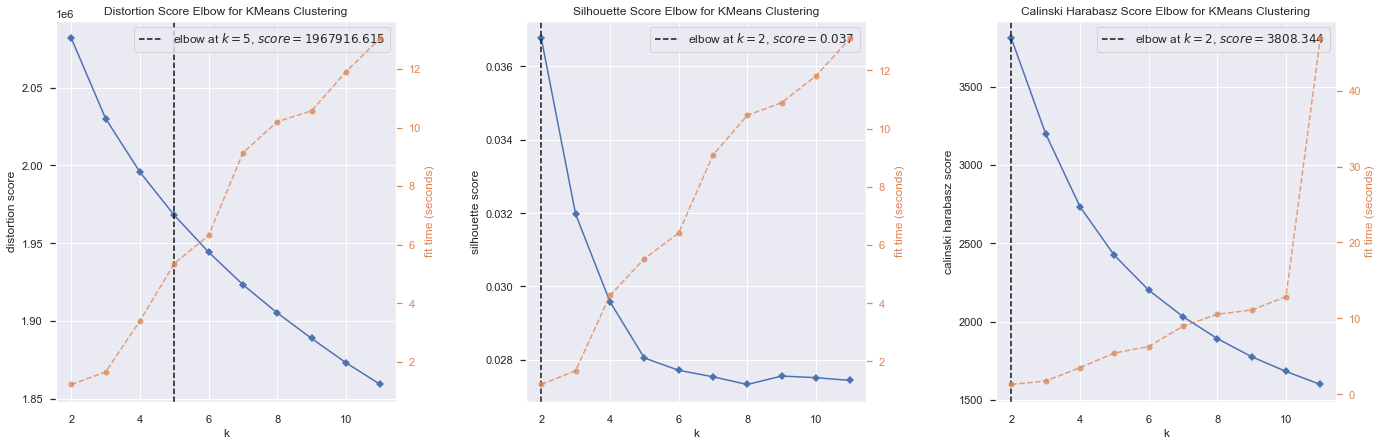

In [57]:
%%time 
plt.figure(figsize=(20, 7))

metrics = ['distortion', 'silhouette', 'calinski_harabasz']

for i, metric in enumerate(metrics):    
    ax = plt.subplot(1,3,i+1)
    visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,12), metric=metric, ax=ax)
    visualizer.fit(X_sc)
    visualizer.finalize() 
    
plt.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar nos gráficos que não temos um ponto definido como cotove.  
    
</div>

## 3.2.1. PCA

In [379]:
feature_grup_1 = df2_train.columns[1:8].to_list()
feature_grup_2 = df2_train.columns[8:15].to_list()
feature_grup_3 = df2_train.columns[23:].to_list()

In [433]:
feature_1_3 = feature_grup_3.copy()

#for col in feature_grup_3:        
#    feature_1_3.append(col)
   
print(feature_grup_2)
print(feature_grup_3)
print(feature_1_3)

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']
['f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']
['f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']


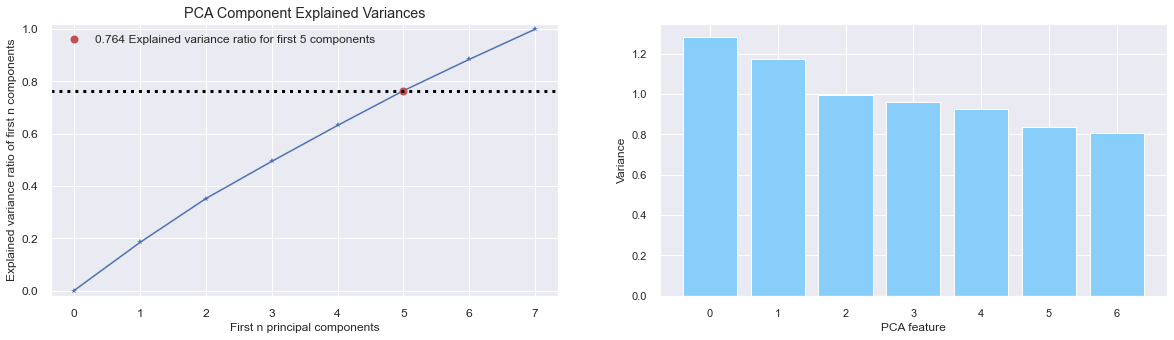

In [434]:
feature_pca = feature_1_3
pca         = PCA(random_state=12359)
pca_X       = pca.fit_transform(X_sc[feature_pca])

#plt.figure(figsize=(20,6))
f1, axs1 = plt.subplots(1,2,figsize=(20,5)) #ROW,COLUMN

skplt.decomposition.plot_pca_component_variance(pca, ax=axs1[0] )


features = range(pca.n_components_)

plt.bar(features[:30], pca.explained_variance_[:], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

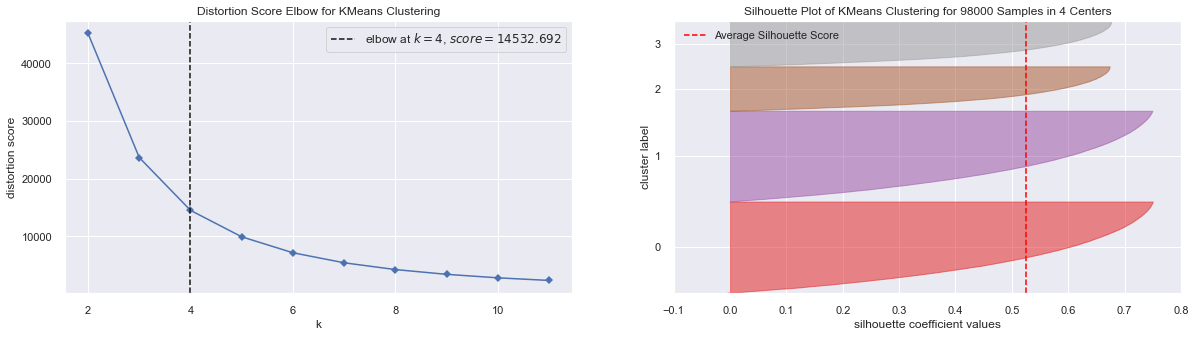

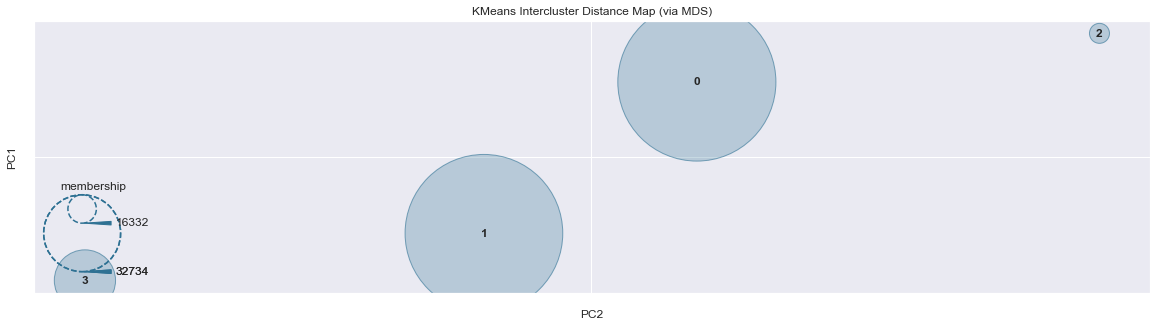

CPU times: total: 5min 56s
Wall time: 4min 23s


<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [435]:
%%time 

n_components  = 1
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]
X_pca_gr1     = pca.fit_transform(X_sc[feature_pca])
model_1       = KMeans(random_state=seed, algorithm='elkan')


f1, axs1 = plt.subplots(1,2,figsize=(20,5)) #ROW,COLUMN

visualizer = KElbowVisualizer(model_1, k=(2,12), timings=False,  ax=axs1[0])
visualizer.fit(X_pca_gr1)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_2 = KMeans(k, algorithm='elkan', random_state=seed)
sv      = SilhouetteVisualizer(model_2, ax=axs1[1])

sv.fit(X_pca_gr1)
sv.show()

f2, axs2 = plt.subplots(1,1,figsize=(20,5)) #ROW,COLUMN

id = InterclusterDistance(KMeans(k, random_state=seed), ax=axs2)
id.fit(X_pca_gr1)
id.show();


# 13 - 14533.521 => 0.01447
# -0.00018

In [436]:
model_2.fit(X_pca_gr1)
cluster = model_2.predict(X_pca_gr1)

In [437]:
df_submission['Predicted'] = cluster
df_submission.to_csv(path + 'Data/submission/04_sub_feature_gr_3.csv', index=False)


In [ ]:
https://notebook.community/DistrictDataLabs/yellowbrick/examples/clustering_visualizers
https://notebook.community/c-north/hdbscan/notebooks/Comparing%20Clustering%20Algorithms
https://notebook.community/tleonhardt/machine_learning/UL2_Clustering
    
    

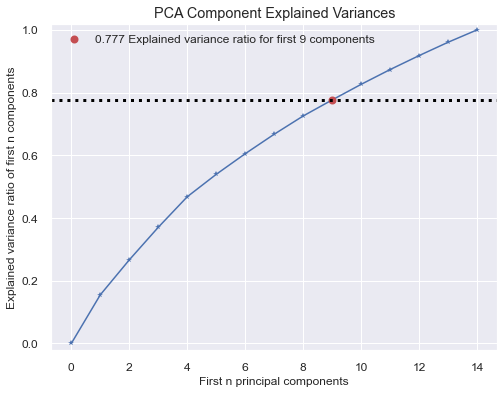

In [211]:
X_gr23 = X_sc[feature_grup_2]
X_gr23[feature_grup_3] = X_sc[feature_grup_3]

feature_pca = feature_grup_1
pca         = PCA(random_state=12359)
pca_X       = pca.fit_transform(X_gr23)

skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));

#X_new[pca_feats] = pca.fit_transform(X_sc)
#X_pca = X_new


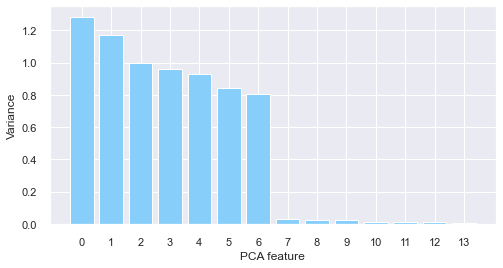

In [159]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

In [175]:
n_components  = 2
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]
X_pca_gr2     = pca.fit_transform(X_gr23)


In [168]:
X_pca = pd.DataFrame(X_pca_gr1, columns=['fe_pca_1'])
X_pca[['fe_pca_2', 'fe_pca_3', 'fe_pca_4'] ]= X_pca_gr2

In [173]:
X_pca= X_pca_gr1

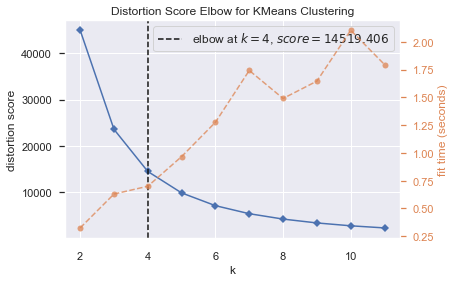

In [174]:
visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,12), )
visualizer.fit(X_pca)
visualizer.finalize() 

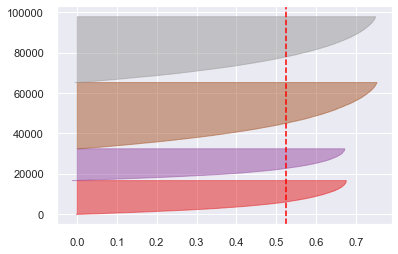

In [176]:
sv = SilhouetteVisualizer(KMeans(4,random_state=0),)
sv.fit(X_pca);

In [181]:
model = KMeans(4,random_state=0).fit(X_pca)
cluster = model.predict(X_pca)
cluster

array([2, 2, 2, ..., 0, 3, 2])

In [ ]:
df_submission['Predicted'] = cluster
df_submission.to_csv(path + 'Data/submission/02_sub_pca.csv', index=False)

In [188]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

ALGORITHM = BayesianGaussianMixture

In [189]:
additional_hyperparams = dict(
    
                                covariance_type = 'full',
                                random_state = 1
                             
                             )

gmm = ALGORITHM(n_components = 4, **additional_hyperparams)
preds = gmm.fit_predict(X_sc)


In [192]:
pd.DataFrame({'m1': preds, 'm2': cluster})

,m1,m2
0,0,2
1,3,2
2,0,2
3,1,2
4,2,2
...,...,...
97995,2,2
97996,2,2
97997,2,0
97998,2,3


In [193]:
df_submission['Predicted'] = preds
df_submission.to_csv(path + 'Data/submission/03_sub_pca.csv', index=False)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
Temos neste primeiro momento 5 cluster, sendo que score é muito alto vamos fazer alguns testes, escrevi uma função para o Kmeans, ela faz as seguintes coisas:


1. Pré-processa o conjunto de dados usando o QuantileTransformer e MinMaxScaler;
2. Traça a curva do cotovelo para o método de distorção selecionando automaticamente o número ideal de clusters;
3. Traça a curva do cotovelo para o método Silhouette e Calinski_Harabasz para validação;
4. Traça o coeficiente de silhueta para todas as amostras
5. Traça a distância do cluster
6. Executa o algoritmo Kmeans para o número ótimo de clusters determinado pelo método de distorção
7. Retorna o dataset com uma nova coluna com o rótulo do cluster

    
</div>

In [ ]:
def Kmeansplots(X_): 

    sc_qt = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=12359)
    sc_mm = MinMaxScaler()

    preprocessor = ColumnTransformer([('scaler QTransformer', sc_qt, feature_float), 
                                      ('scaler MinMaxScaler', sc_mm, feature_int)])

    plt.figure(figsize=(20, 15))

    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    ax4 = plt.subplot(2,2,3)
    ax5 = plt.subplot(2,2,4)

    k = (2,10)

    kv_1 = KElbowVisualizer(KMeans(), K=k, metric='distortion', ax=ax1)
    kv_2 = KElbowVisualizer(KMeans(), K=k, metric='silhouette', ax=ax2)
    kv_3 = KElbowVisualizer(KMeans(), K=k, metric='calinski_harabasz', ax=ax3)

    visual_grid1 = [
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", kv_1)]), 'kelbowvisualizer'),    
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", kv_2)]), 'kelbowvisualizer'),
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", kv_3)]), 'kelbowvisualizer')]

    for i, viz in enumerate(visual_grid1):    
        viz[0].fit(X_)    
        if i==0:
            #Defining the best K by distortion method      
            K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 

        viz[0].named_steps[viz[1]].finalize()

    sv_01 = ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K,random_state=0),ax=ax4)) 
    sv_02 = ("distancevisualizer", InterclusterDistance(KMeans(K,random_state=0),ax=ax5))

    visual_grid2 = [(Pipeline([("preprocessor", preprocessor), sv_01]), 'silhouettevisualizer'),                
                    (Pipeline([("preprocessor", preprocessor), sv_02]), 'distancevisualizer')]

    for viz in visual_grid2:
        viz[0].fit(X_)
        viz[0].named_steps[viz[1]].finalize()

    plt.tight_layout(pad=3.0)

    kmeans_model = Pipeline([("preprocessor", preprocessor),
                             ("kmeans", KMeans(K,random_state=0))])
    
    kmeans_model.fit(X_)
    
    # Kmeans labels
    kmeans_labels      = kmeans_model.named_steps['kmeans'].labels_  
    X_["kmeans_label"] = kmeans_labels
    
    return X_

In [ ]:
X_1 = Kmeansplots(X.copy())

In [ ]:
df_submission['Predicted'] = X['kmeans_label']
df_submission.to_csv(path + 'Data/submission/01_base_line.csv', index=False)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

O método de 3 cotovelos definiu o número ótimo de clusters como 3. Os gráficos Silhouette mostraram um alto coeficiente de silhueta para todos os registros, significando que os clusters são densos. Pelo gráfico de interdistância, fica evidente que os aglomerados estão distantes uns dos outros.

        
</div>

In [ ]:
pd.DataFrame(preprocessor.fit_transform( X.head()))

In [ ]:
X.groupby(['kmeans_label']).agg({'kmeans_label':'count',  
                                #   'Sel_Others':'sum',
                                #   'Sel_Southeast':'sum',
                                #   'Sel_South':'sum'
                                })

In [ ]:
feature_int

In [ ]:
fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
X.groupby(['kmeans_label']).agg({'f_07':'mean', 
                                 'f_09':'mean',
                                 'f_10':'mean',
                                 'f_11':'mean',
                                 'f_12':'mean',
                                 'f_13':'mean',
                                 
                                   }).plot.bar(ax = axes,
                                          title = 'Average Number of Sales per Category per Cluster');


axes = plt.subplot2grid((1,2),(0,1))                                   
X.groupby(['kmeans_label']).agg({'f_07':'median', 
                                   'f_09':'median',
                                   'f_10':'median',
                                   'f_11':'median',
                                   'f_12':'median',
                                   'f_13':'median',
                                   }).plot.bar(ax = axes,
                                          title = 'Median Number of Sales per Category per Cluster');

In [ ]:
aux = X.columns
fig = plt.figure(figsize=(24,28))
a = 0; b=0
for i in aux[8:19]:
    axes = plt.subplot2grid((4,3),(a,b))
    sns.violinplot(x = X['kmeans_label'],y = X[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')  
    b = b+1
    if b>=3:
      b = 0
      a = a+1

In [ ]:
X_sc.head()

In [ ]:
data_1_reduced = X_sc

plt.figure(figsize=(24, 8))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='ward',metric='euclidean')
dend = shc.dendrogram(link, color_threshold=11000)  

### 3.3.2. Featuere Importance

In [ ]:
features       = pd.Series(model_baseline.feature_importances_)
features.index = cols

features.sort_values(ascending=True, inplace=True)
features.plot(kind ='barh', figsize=(15,15));

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Olhando as variáveis mais importante, obeservamos que a maioria das variáveis que identificamos como categoricas aparecem entre as mais importantes.  
    
</div>

## 3.4. Validação Cruzada

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0
   # col_prob        = y_.sort_values().unique()
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    test_pred_proba = np.zeros((1, 1))
    preds           = []
    model           = []
    
    for i, scaler_ in enumerate(scalers_): 

        time_start = datetime.now()
        score      = []        
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        pred_test=0 
        
        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)[:,1]    
            y_pred_val      = (y_pred_val_prob>.5).astype(int)

            preds.append(model_.predict(X_tst))    
            
            pred_test += model_.predict_proba(X_tst)[:, 1] / folds.n_splits
                
            df_prob_temp    = pd.DataFrame(y_pred_val_prob)
            #y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx            
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = y_pred_val_prob
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
            f1    = metrics.f1_score(y_val, y_pred_val) 
            prec  = metrics.log_loss (y_val, y_pred_val)
            
            score.append(auc)     
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['auc_'+str(fold+1)] = auc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
            print(msg.format(fold+1, auc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)

        score_mean = np.mean(score) 
        score_std  = np.std(score)

        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] AUC: {:2.5f} std: {:2.5f} - {}'.format(score_mean, score_std, time_end))
        print('='*taco)
        print()
               
        if save_submission_:
            name_file_sub  = model_name_ + '_' + str(i+1) + '_' + str(scaler_).lower()[:4] + '.csv'
            name_file_sub  = path_ + 'Data/submission/' + name_file_sub.format(score_mean)        
            df_sub         = df_submission.copy()
            df_sub[target] = pred_test
            df_sub.to_csv(name_file_sub, index=False)
            
        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model, df_prob_temp.sort_values(by=['scaler','id']) , feature_imp 

In [ ]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [StandardScaler(), 
               QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 1000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X,
                    y_               = y,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = True)
print()

## 3.5. Análise do Modelo 
Vamos fazer o treinamento novamente do melhor modelo, sendo que agora vamos utilizar a divisão de treino/teste, isto é, vamos o treino em um conjunto de dados e fazer a previsões em dados que o modelo não viu no treino. 

In [ ]:
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = False)
print()

### 3.5.1. Feature Importances  

In [ ]:
plt.figure(figsize=(15,12))
for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'auc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(3,2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

### 3.5.2. Shap

In [ ]:
mdl = model[1]['model']
sc  = model[1]['scaler']

X_valid_sc = sc.transform(X_valid)#, columns=X_valid.columns)
y_pred_val = mdl.predict_proba(X_valid_sc)[:,1]
score      = metrics.roc_auc_score(y_valid, y_pred_val)

print('AUC em dados não viscto: {:2.5f}'.format(score))

In [ ]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_valid_sc)

shap.summary_plot(shap_values, X_valid_sc, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_valid_sc, max_display=15)

### 3.1.1. Erro e  número de Estimadores

In [ ]:
for erro in eval_metric:
    plt.figure(figsize=(15,10))

    for i in range(len(model)):
        results     = model[i]['model'].evals_result() # merror
        ntree_limit = model[i]['model'].best_ntree_limit

        plt.subplot(2,3,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

       # plt.xlabel('Número de árvores')
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 1000 estimadores é mais que suficiente para o treinamento do modelo, já na predição utilizamos 536 estimadores que torna as predições mais performáticas, esse parametro pode ajuda na tunning do XGB.  
    
</div>

### 3.1.2. Previsão 

In [ ]:
scaler_tr  = model[1]['scaler']
model_tr   = model[1]['model']
X_valid_sc = pd.DataFrame(scaler_tr.transform(X_valid), columns=X_valid.columns)

y_pred_prob = model_tr.predict_proba(X_valid_sc.values, ntree_limit=model_tr.best_ntree_limit)[:,1]
y_pred      = (y_pred_prob >.5).astype(int)
auc         = metrics.roc_auc_score(y_valid, y_pred_prob)

print('AUC: {:2.5f}'.format(auc))

### 3.1.3. Matriz de Confusão

In [ ]:
def plot_cm(preds,true,ax=None):
    cm = confusion_matrix(preds.round(), true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False, values_format = '.6g')
    plt.title('Confusion matrix \n')
    plt.grid(False)
    return disp

plot_cm(y_pred, y_valid);

In [ ]:
threshold = .47

y_pred_threshold     = (y_pred_prob>threshold).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_threshold)

plot_roc_curve(fpr, tpr, label="XGB")
plt.show()

print('AUC     : {:2.5f} '.format(metrics.roc_auc_score(y_valid, y_pred_prob) ))
print('F1-score: {:2.5f}'.format(metrics.f1_score(y_valid, y_pred)))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y_valid, y_pred_threshold), threshold))

<div class="alert alert-info" role="alert"> 
  
CONCLUSÃO: <BR>
Agora temos uma noção do conjunto de dados para esse competição e uma linha de base com o classificador XGB, que se mostrou promissor nas submissões, obtive os sequintes resultados: 0.93628 e 0.93935 todos melhores que o treinamento do modelo, isso demostra que o modelo é robusto e teve uma boa generalização nos dados de teste que tem aproximadamente 29% dos dados, esse é um ponto importante que temos que considerar, pois no final da competição nosso modelo terá que ter um performance em todo o conjunto de dados. 
    
    
Os próximos passos são: <br>

- Feature Engineering     
Ainda há muito a explorar dentro do conjunto de dados, recomendo explorar as variáveis que se relacionam com a variável de destino. Com base nessas relações, podemos criar mais variáveis que são combinações de dois ou mais variaveis. Um exemplo seria a variável C que é formada pelas variáveis A x B. Além disso, a variável f_27 precisa ser examinada com mais detalhes. Pode haver informações importantes escondidas em todos essas variáveis aparentemente sem sentido; 
<br>
    
- Tunning de hyperparametros     
Neste notebook não nos aprofundamos no tunning de hyperparametro do classificado XGB, é outro ponto importante mesmo que o ganho seja pouco, o tunning faz com que os modelos se tornem mais robusto e qualquer ganho pode melhora a nosso colocação na competição;
    
   
    
</div>